### Lecture 3

In [1]:
#importing all the libraries
import torch
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
torch.cuda.is_available()

False

In [3]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')


device

device(type='cpu')

In [4]:
#lenght of the noise that is going to be given to the generator (random-gaussian distribution)
noise_dim = 100

#### Generator Model

In [5]:
#defining the generator model

class Generator(torch.nn.Module):
    
    def __init__(self):
        
        super(Generator, self).__init__()
        
        self.fcn = torch.nn.Sequential(
            # Fully Connected Layer 1
            torch.nn.Linear(
                in_features=noise_dim,
                out_features=1200,
                bias=True
            ),
            torch.nn.ReLU(), #Activation function
            torch.nn.Dropout(), #Regularization
            # Fully Connected Layer 2
            torch.nn.Linear(
                in_features=1200,
                out_features=1200,
                bias=True
            ),
            torch.nn.ReLU(),
            torch.nn.Dropout(),
            # Fully Connected Layer 3
            torch.nn.Linear(
                in_features=1200,
                out_features=1200,
                bias=True
            ),
            torch.nn.ReLU(),
            torch.nn.Dropout(),
            # Fully Connected Layer 4
            torch.nn.Linear(
                in_features=1200,
                out_features=784,
                bias=True
            ),
            torch.nn.Sigmoid() # sigmoid activation / squelching function [0 1]
        )

    def forward(self, batch):
        ret = batch.view(batch.size(0), -1) #Flattening the input
        ret = self.fcn(ret) # Fully connected network above
        return ret

#### Maxout Activation

##### Source: https://github.com/pytorch/pytorch/issues/805

In [6]:
class Maxout(torch.nn.Module):

    def __init__(self, num_pieces):

        super(Maxout, self).__init__()

        self.num_pieces = num_pieces #number of pieces of the activation function

    def forward(self, x):

        # x.shape = (batch_size? x 625)
        # Batch is 2 dimentional matrix
        # dimetion of the batch is divisible by the number of pieces of the constructor
        assert x.shape[1] % self.num_pieces == 0  # 625 % 5 = 0
        
        #reshaping the batch to be 4 dimentional
        ret = x.view(
            *x.shape[:1],  # batch_size
            x.shape[1] // self.num_pieces,  # piece-wise linear
            self.num_pieces,  # num_pieces
            *x.shape[2:]  # remaining dimensions if any
        )
        
        # ret.shape = (batch_size? x 125 x 5)

        # https://pytorch.org/docs/stable/torch.html#torch.max 
        # max along the thrid dimention (number of pieces)
        ret, _ = ret.max(dim=2)

        # ret.shape = (batch_size? x 125)

        return ret

#### Discriminator Model

In [7]:
class Discriminator(torch.nn.Module):
    
    def __init__(self):
        
        super(Discriminator, self).__init__()
        
        self.fcn = torch.nn.Sequential(
            # Fully Connected Layer 1
            torch.nn.Linear(
                in_features=784,
                out_features=625,
                bias=True
            ),
            Maxout(5),#MaxOut activation
            # Fully Connected Layer 2
            torch.nn.Linear(
                in_features=125,
                out_features=625,
                bias=True
            ),
            Maxout(5), #MaxOut activation
            # Fully Connected Layer 3
            torch.nn.Linear(
                in_features=125,
                out_features=1,
                bias=True
            ),
            torch.nn.Sigmoid() #Sigmoid activation function
        )

    def forward(self, batch):
        ret = batch.view(batch.size(0), -1)
        ret = self.fcn(ret)
        return ret

### Lecture 4

#### MNIST Dataset

In [8]:
import torchvision

In [9]:
class FlattenTransform:
    
    def __call__(self, inputs):
        return inputs.view(inputs.shape[0], -1)
        

data_train = torchvision.datasets.MNIST(
    './data/mnist',
    train=True,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(), #Convert from 0-255 to 0-1
        FlattenTransform() #Flatten the image to 1d vector
    ])
)

Extracting ./data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw


Extracting ./data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw


Extracting ./data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw


Extracting ./data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw
Processing...


/home/stephany/miniconda3/envs/pytorch_env/lib/python3.6/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729004493/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!





In [10]:
BATCH_SIZE = 32

#set the dataloader from the dataset
train_loader = torch.utils.data.DataLoader(
    data_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4
)

#### GAN Training

In [11]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

#Optimizer Stocastic Gradient Descent
discriminator_optimizer = torch.optim.SGD(
    discriminator.parameters(),
    lr=0.005, #0.005
    momentum=0.7 #0.7
)

generator_optimizer = torch.optim.SGD(
    generator.parameters(),
    lr=0.005, #0.005
    momentum=0.7 #0.7
)

#Loss function - Binary cross entropy
criterion = torch.nn.BCELoss()

In [12]:
#Real labels = 1
real_labels = torch.ones(BATCH_SIZE, 1).to(device)
#Fake labels = 0
fake_labels = torch.zeros(BATCH_SIZE, 1).to(device)

#Fixed noise, 16 samples
test_set = torch.randn(16, noise_dim).to(device)

#Number of epochs
num_epochs = 512
#Number of steps
num_steps = len(train_loader) // BATCH_SIZE

In [13]:
import os

if not os.path.exists('visuals'):
    os.mkdir('visuals')

In [14]:
#For each epoch
for epoch in range(num_epochs):

    for i, (images, _) in enumerate(train_loader):

        if i == num_steps:
            break

        # Train Discriminator
        # Training the discriminator 8 times 
        for _ in range(8): #16
        
            real_images = images.to(device)
            
            # Generating fake images from random noise
            fake_images = generator(
                torch.randn(BATCH_SIZE, noise_dim).to(device)
            )

            # Reseting the gradients in the discriminator optimizer
            discriminator_optimizer.zero_grad()
            
            # Feeding the discriminator with both real and fake images
            real_outputs = discriminator(real_images)
            fake_outputs = discriminator(fake_images)

            # Apply the loss function twice, for real and fake outputs
            d_x = criterion(real_outputs, real_labels)
            d_g_z = criterion(fake_outputs, fake_labels)

            # Calculate the gradients
            d_x.backward()
            d_g_z.backward()

            # Update the weights 
            discriminator_optimizer.step()

        # Train Generator
        z = torch.randn(BATCH_SIZE, noise_dim).to(device)
        
        # reseting the gradients
        generator.zero_grad()
        
        # Obtain the output of the discriminator 
        outputs = discriminator(generator(z))
        
        # Pass the outputs and the labels to the loss function
        loss = criterion(outputs, real_labels)
        
        # Calulate the gradients
        loss.backward()
        
        # Update the weights
        generator_optimizer.step()

    # Visualize Results
    if epoch % 10 == 0:
        # Reshape the output to the original size (batch size, channel, width, height )
        generated = generator(test_set).detach().cpu().view(-1, 1, 28, 28)

        grid = torchvision.utils.save_image( #Saves a grid 
            generated,
            os.path.join(
                'visuals', #Directory
                '{}.jpg'.format( #Name of the file
                    str(epoch).zfill(6)
                )
            ),
            nrow=4, #size of the grid
            padding=10, #distance between the images
            pad_value=1 #color of the distance between the images
        )

KeyboardInterrupt: 

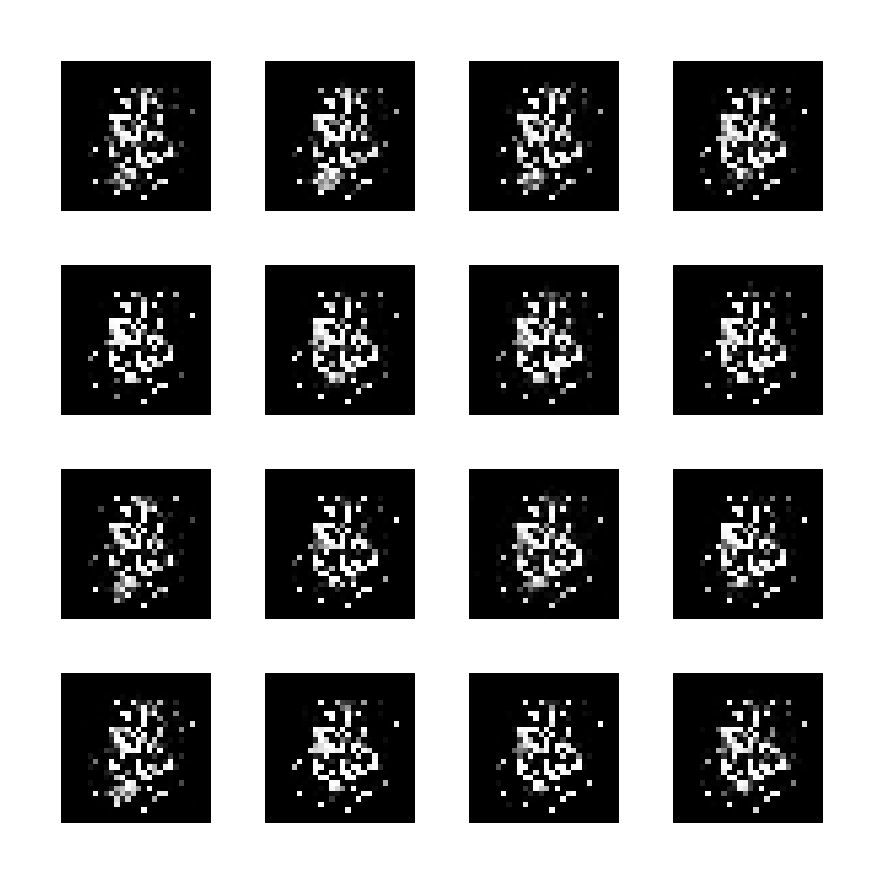

In [15]:
# Visualize Results
generated = generator(test_set).detach().cpu().view(-1, 1, 28, 28)

grid = torchvision.utils.make_grid( #Grid variable (tensor)
    generated,
    nrow=4,
    padding=10,
    pad_value=1
)

img = np.transpose( #Change the order of the dimensions
    grid.numpy(),
    (1, 2, 0)
)

fig = plt.figure(figsize=(16, 16))
plt.axis("off")
plt.imshow(img);

#### Google Collaboratory

Notebook: https://colab.research.google.com/drive/14zSDErgZ8cNn9UEHgh2x2tPhao9HVYn5